In [1]:
from Utils.loadset import getDataSet
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow_probability as tfp
import os
physical_devices = tf.config.list_physical_devices('GPU') 
print("Num GPUs:", len(physical_devices)) 

from trainer import Trainer
try:
    from Utils.connection_cfg import *
except Exception as e:
    PSWD = None
    USRN = None
    
from Utils.Data import dataWrapper
from Utils.transform import cutOut,NormalDist

Num GPUs: 1
Num GPUs Available: 1


Using TensorFlow backend.


In [2]:
dimension = (128,128)
channels = 5
optimizer = Adam( lr = 1e-3 )
slices = [224,352,224,352]
slices_label = [32,64+32,32,64+32]
cutOutFrame = cutOut(slices)
cutOutFrame_label = cutOut(slices_label)

PRETRAINING_TRANSFORMATIONS = [cutOutFrame]
TRANSFORMATION = [cutOutFrame_label]
tfd = tfp.distributions
def NLL(y_true, y_hat):
    return -y_hat.log_prob(y_true[:,:])
                           
def mixd(output):
    rate = tf.math.exp(output[0,:,:,0]) #A 
    s = tf.math.sigmoid(output[0,:,:,1])
    components = [tfd.Deterministic(loc=tf.zeros_like(rate)), #E
     tfd.Poisson(rate=rate) #F 
     ]
    mixture = tfd.Mixture(
          cat=tfd.Categorical(probs=tf.stack([1-s, s],axis=-1)),#D
          components=components)
    
    return mixture
    
def testnetNormalDist(input_shape,
           n_predictions=1,
           simpleclassification=None,
           flatten_output=False,
           activation_hidden="relu",
           activation_output="relu"):


    inputs = Input(shape=input_shape) 

    conv01 = Conv2D(10, kernel_size=(3, 3), padding="same")(inputs)       # 10 x 64x64
    conv01 = Activation(activation_hidden)(conv01)
    conv01_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv01)            # 10 x 32x32


    conv02 = Conv2D(20, kernel_size=(3, 3), padding="same")(conv01_pool)  # 20 x 32x32
    conv02 = Activation(activation_hidden)(conv02)
    conv02_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv02)            # 20 x 16x16


    conv03 = Conv2D(20, kernel_size=(3, 3), padding="same")(conv02_pool)  # 20 x 16x16
    conv03 = Activation(activation_hidden)(conv03)
    conv03_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv03)            # 20 x 8x8


    conv04 = Conv2D(20, kernel_size=(3, 3), padding="same")(conv03_pool)  # 20 x 8x8
    conv04 = Activation(activation_hidden)(conv04)
    conv04_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv04)            # 20 x 4x4


    ### UPSAMPLING:
    up04 = UpSampling2D((2, 2))(conv04_pool)    # 20 x 8x8
    up04 = concatenate([conv04, up04], axis=3)  # 20+20 x 8x8


    up03 = UpSampling2D((2, 2))(up04)           # 40 x 16x16
    up03 = concatenate([conv03, up03], axis=3)  # 20+40 x 16x16


    up02 = UpSampling2D((2, 2))(up03)           # 60 x 32x32
    up02 = concatenate([conv02, up02], axis=3)  # 20+60 x 32x32


    up01 = UpSampling2D((2, 2))(up02)           # 80 x 64x64
    up01 = concatenate([conv01, up01], axis=3)  # 10+80 x 64x64
    up01 = MaxPooling2D((2, 2), strides=(2, 2))(up01)
    
    layer = Conv2D(2, (1, 1), activation="sigmoid")(up01)  # 1 x 64x64
    
    
    layer_1 = Flatten()(layer[:,:,:,:1])
    layer_2 = Flatten()(layer[:,:,:,1:2])
    layer_1 = Dense(64*64,activation="linear")(layer_1)
    layer_2 = Dense(64*64,activation="linear")(layer_2)
    
    layer_stacked = tf.stack([layer_1,layer_2],axis=-1)
    layer = tf.reshape(layer_stacked, tf.shape(layer))
    
    #output = Dense(64*64*2,activation="selu")(layer)
    #output = Activation(tf.math.softplus)(output)
    
    output = tfp.layers.IndependentNormal(1)(layer)
    model = Model(inputs=inputs, outputs=output)
    return model

def provideData(flatten=False,dimension=dimension,batch_size=10,transform=TRANSFORMATION,preTransformation=PRETRAINING_TRANSFORMATIONS):

    getDataSet(DatasetFolder,year=[2017],username=USRN,pswd=PSWD)
    train,test = dataWrapper(PathToData,
                            dimension=dimension,
                            channels=channels,
                            batch_size=batch_size,
                            overwritecsv=True,
                            flatten=flatten,
                            onlyUseYears=[2017],
                            transform=transform,
                            preTransformation=preTransformation)
    
    return train,test
DatasetFolder = "./Data/RAW"
PathToData = os.path.join(DatasetFolder,"MonthPNGData")

In [3]:

optimizer = Adam( lr = 1e-3 )
batch_size=200
tfd = tfp.distributions
def NLL(y_true, y_hat):
    return -y_hat.log_prob(y_true)

train, test = provideData(flatten=False,dimension=dimension,batch_size=batch_size,transform=TRANSFORMATION,preTransformation=PRETRAINING_TRANSFORMATIONS)

Found Year :  2017 => won't download this year again... please check for consistency
Finished Loading Dataset
 


In [4]:
model_normal = testnetNormalDist((*dimension,5))
model_normal.compile(loss=lambda y, model_normal: -model_normal.log_prob(y), optimizer=Adam( lr= 1e-3 ),metrics = ["mse","mae"])
model_normal.summary()

print("len train,val",len(train),len(test))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 5) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 10) 460         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 10) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 10)   0           activation[0][0]                 
______________________________________________________________________________________________

In [5]:
model_normal.fit(train,epochs=20)

/home/simon/Dokumente/Teamprojekt/DeepRain2/Networks/Utils/transform.py:98: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return img[self.slices]


Epoch 1/20
394/394 [==============================] - 93s 236ms/step - loss: 0.9849 - mse: 6.4950 - mae: 1.0781
Epoch 2/20
394/394 [==============================] - 93s 237ms/step - loss: 0.4209 - mse: 0.3835 - mae: 0.4898
Epoch 3/20
394/394 [==============================] - 94s 238ms/step - loss: 0.2818 - mse: 0.3130 - mae: 0.4352
Epoch 4/20
394/394 [==============================] - 93s 236ms/step - loss: 0.1140 - mse: 0.2522 - mae: 0.3809
Epoch 5/20
394/394 [==============================] - 93s 237ms/step - loss: -0.0795 - mse: 0.2013 - mae: 0.3293
Epoch 6/20
394/394 [==============================] - 94s 239ms/step - loss: -0.2958 - mse: 0.1592 - mae: 0.2817
Epoch 7/20
394/394 [==============================] - 94s 237ms/step - loss: -0.5298 - mse: 0.1247 - mae: 0.2386
Epoch 8/20
394/394 [==============================] - 94s 239ms/step - loss: -0.7746 - mse: 0.0968 - mae: 0.2002
Epoch 9/20
394/394 [==============================] - 93s 237ms/step - loss: -1.0166 - mse: 0.0744 -

In [6]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import figure
import numpy as np
%matplotlib inline


In [7]:
model = model_normal
pred = None
label = None
test.on_epoch_end()
mean = []
stdev = []
label = []
for x,y in train:
    for i in range(batch_size):
        if y[i,:,:,:].max() >= -0.4:
            pred = model(np.array([x[i,:,:,:]]))
            mean.append(pred.mean() )
            stdev.append(pred.stddev())
            label.append(y[i,:,:,:])
        #mean = model(x).mean()
        #std = model(x).stddev()
        #label = y
        break

/home/simon/Dokumente/Teamprojekt/DeepRain2/Networks/Utils/transform.py:98: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return img[self.slices]


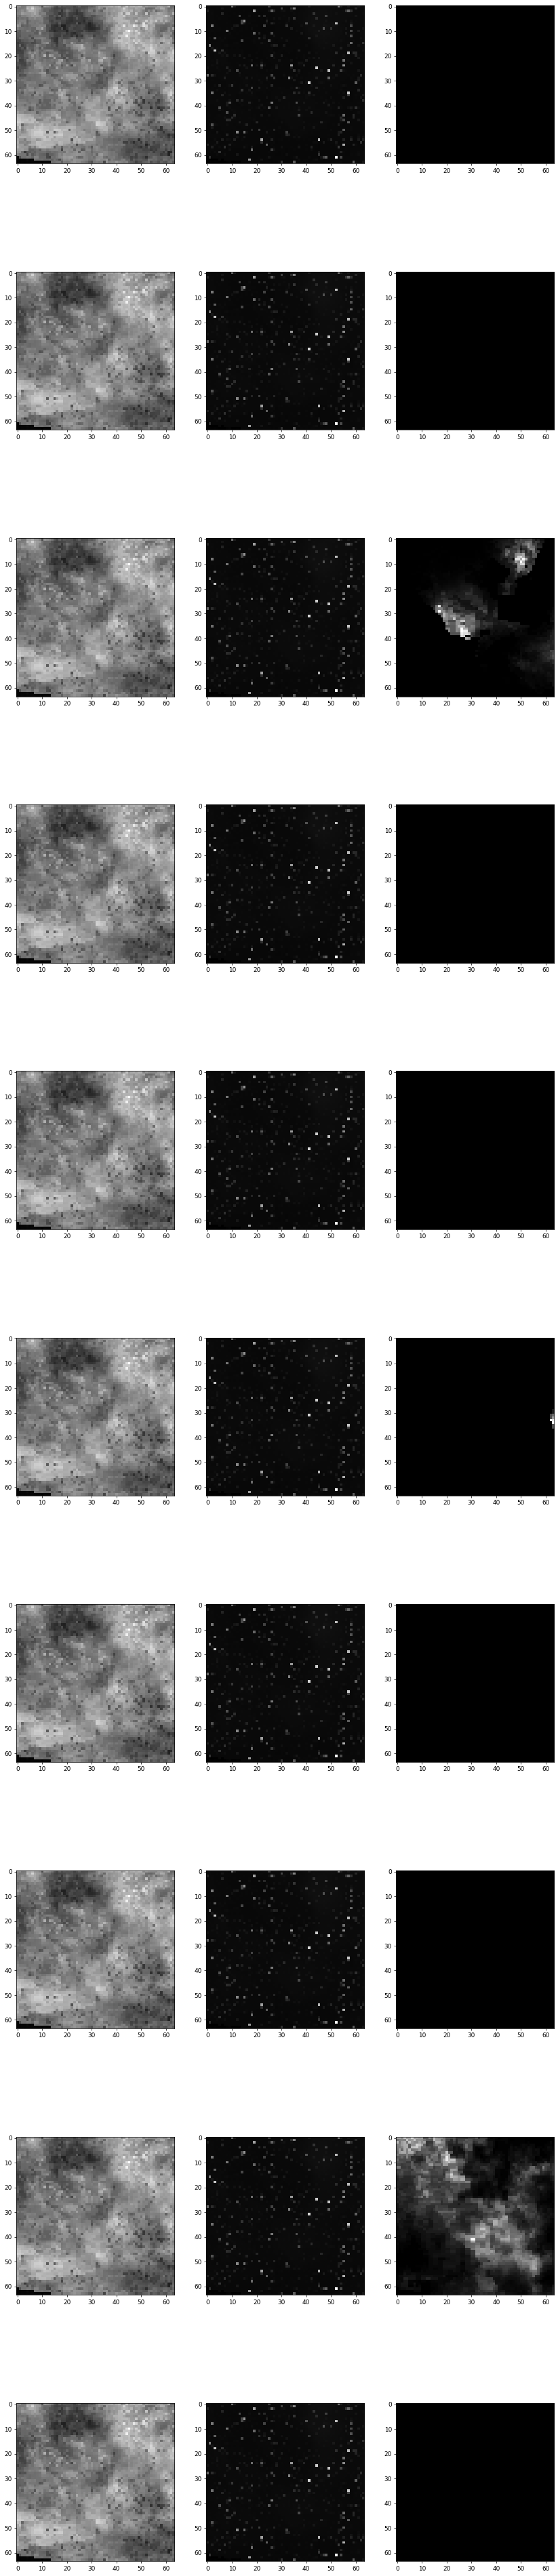

In [8]:
fig, axes = plt.subplots(10, 3, figsize=(16,8*10),dpi=64)
#fig.set_title(["mean","stdev","label"])
for batch,img in enumerate(mean):
    if batch == 10:
        break
    axes[batch,0].imshow(img[0,:,:,0],cmap="gray")
    axes[batch,1].imshow(stdev[batch][0,:,:,0],cmap="gray")
    axes[batch,2].imshow(label[batch][:,:,0],cmap="gray")